In [1]:
import odc.geo.xr
from odc.geo.gridspec import GridSpec
from odc.geo.geom import BoundingBox
from odc.geo.types import xy_

import numpy as np
import geopandas as gpd
from dea_tools.spatial import xr_interpolate
import dea_tools
from dea_tools.datahandling import load_reproject
from rasterio.enums import Resampling

In [2]:
import rioxarray

path = r"C:\Users\danie\OneDrive - The University Of Newcastle\2025\SCIE3500\Data\LiDAR\5m_DEM_WoodyHead.tif"

In [3]:
import xarray as xr
ds = xr.open_dataset(path)
# ds = ds.astype("float32")  # 💾 Convert to float32 to save memory


In [4]:
ds

<xarray.Dataset> Size: 563MB
Dimensions:      (band: 1, x: 13701, y: 10276)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 110kB 152.7 152.7 152.7 152.7 ... 153.4 153.4 153.4
  * y            (y) float64 82kB -29.34 -29.34 -29.34 ... -29.8 -29.8 -29.8
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 563MB ...

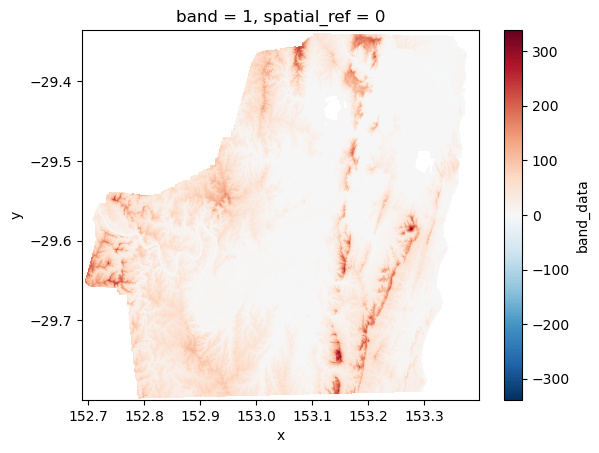

In [5]:
ds.band_data.plot()

In [ ]:
ds.band_data.plot(vmin=0, vmax=11)

In [6]:
from odc.geo.gridspec import GridSpec
from odc.geo.types import xy_

gs_c3_expanded = GridSpec(
    crs="EPSG:3577",
    resolution=5,
    #tile_shape=(19200, 19200),
    tile_shape=(10000, 10000),
    origin=xy_(-4416000, -6912000)  # Keep your origin point the same
)


In [7]:
# Visualising whole grid
# Set bounding box
c3_bbox = BoundingBox(
    left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs="EPSG:3577"
)

# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_c3_expanded.geojson(bbox=c3_bbox),
    crs="EPSG:4326",
)
grid_gdf.explore()

# If multiple tiles

In [8]:
from odc.geo.geobox import GeoBox

In [9]:
import odc.geo.geobox
print(dir(odc.geo.geobox))

['Affine', 'AnchorEnum', 'Any', 'BoundingBox', 'CRS', 'Callable', 'Chunks2d', 'Coordinate', 'Dict', 'GeoBox', 'GeoBoxBase', 'GeoboxAnchor', 'GeoboxTiles', 'Geometry', 'Iterator', 'List', 'Literal', 'Mapping', 'MaybeCRS', 'MaybeInt', 'NormalizedROI', 'Optional', 'OrderedDict', 'OutlineMode', 'ROI', 'Resolution', 'RoiTiles', 'Sequence', 'Shape2d', 'SomeCRS', 'SomeIndex2d', 'SomeResolution', 'SomeShape', 'Tuple', 'Union', 'Unset', 'XY', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_norm_anchor', '_round_to_res', 'affine_transform_pix', 'align_up', 'annotations', 'bbox_intersection', 'bbox_union', 'bounding_box_in_pixel_domain', 'clamp', 'clip_tiles', 'extract_anchor', 'flipx', 'flipy', 'func2map', 'gbox_boundary', 'geobox_intersection_conservative', 'geobox_union_conservative', 'geom', 'importlib', 'is_affine_st', 'is_almost_int', 'itertools', 'math', 'maybe_zero', 'namedtuple', 'norm_crs', 'numpy', 'pad', 'pad_wh', 'pixel_tran

2 tiles

In [ ]:
from odc.geo.geobox import GeoBox  # Ensure GeoBox is imported
from shapely.geometry import box

# Extract GeoBoxes
bbox1 = (121, 58)
bbox2 = (121, 57)

geobox1 = gs_c3_expanded[bbox1]
geobox2 = gs_c3_expanded[bbox2]


# Convert extent to Shapely bounding box and extract bounds
min_x1, min_y1, max_x1, max_y1 = geobox1.extent.geom.bounds
min_x2, min_y2, max_x2, max_y2 = geobox2.extent.geom.bounds

# Determine overall bounding box
min_x = min(min_x1, min_x2)  
max_x = max(max_x1, max_x2)
min_y = min(min_y1, min_y2)
max_y = max(max_y1, max_y2)

# Get resolution and CRS from one of the existing GeoBoxes
resolution = geobox1.resolution
crs = geobox1.crs

# Create a new GeoBox that covers all four
combined_geobox = GeoBox.from_bbox((min_x, min_y, max_x, max_y), resolution=resolution, crs=crs)

# Visualize
combined_geobox.explore()


3 tiles

In [10]:
from odc.geo.geobox import GeoBox
from shapely.geometry import box

# Extract GeoBoxes from the GridSpec
bbox1 = (127, 70)
bbox2 = (128, 70)
bbox3 = (129, 70)  # Example third tile – adjust as needed

geobox1 = gs_c3_expanded[bbox1]
geobox2 = gs_c3_expanded[bbox2]
geobox3 = gs_c3_expanded[bbox3]

# Get bounds of each GeoBox
min_x1, min_y1, max_x1, max_y1 = geobox1.extent.geom.bounds
min_x2, min_y2, max_x2, max_y2 = geobox2.extent.geom.bounds
min_x3, min_y3, max_x3, max_y3 = geobox3.extent.geom.bounds

# Determine the combined bounding box
min_x = min(min_x1, min_x2, min_x3)
max_x = max(max_x1, max_x2, max_x3)
min_y = min(min_y1, min_y2, min_y3)
max_y = max(max_y1, max_y2, max_y3)

# Get resolution and CRS from any one of the geoboxes (they should match)
resolution = geobox1.resolution
crs = geobox1.crs

# Create the combined GeoBox
combined_geobox = GeoBox.from_bbox((min_x, min_y, max_x, max_y), resolution=resolution, crs=crs)

# Visualize
combined_geobox.explore()


4 tiles

In [ ]:
from odc.geo.geobox import GeoBox
from shapely.geometry import box

# Extract GeoBoxes from 4 tiles
geoboxes = [
    gs_c3_expanded[(128, 72)],
    gs_c3_expanded[(129, 72)],
    gs_c3_expanded[(128, 71)],
    gs_c3_expanded[(129, 71)],
]

# Get bounds from each and calculate the overall extent
all_bounds = [g.extent.geom.bounds for g in geoboxes]

min_x = min(b[0] for b in all_bounds)
min_y = min(b[1] for b in all_bounds)
max_x = max(b[2] for b in all_bounds)
max_y = max(b[3] for b in all_bounds)

# Assume resolution and CRS are the same across all tiles
resolution = geoboxes[0].resolution
crs = geoboxes[0].crs

# Create a combined GeoBox
combined_geobox = GeoBox.from_bbox((min_x, min_y, max_x, max_y), resolution=resolution, crs=crs)

# Optional: Visualize the GeoBox
combined_geobox.explore()


In [11]:
ds2 = load_reproject(
    path=r"C:\Users\danie\OneDrive - The University Of Newcastle\2025\SCIE3500\Data\LiDAR\5m_DEM_WoodyHead.tif",
    how=combined_geobox,
    masked=True  
)
ds2.odc.explore()


c:\Users\danie\OneDrive\Documents\Notebook\.conda\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get center x index
x_index = ds2.sizes['x'] // 2

# Force Dask to compute the data
transect = ds2.isel(x=x_index).values  # or use .load() if needed

# If still empty, print first few values
print(transect[:10])
print("Min:", np.nanmin(transect), "Max:", np.nanmax(transect))

# Plot only if values are valid
if not np.isnan(transect).all():
    plt.plot(transect)
    plt.title(f"Elevation Transect at x={x_index}")
    plt.xlabel("Y Index")
    plt.ylabel("Elevation (m)")
    plt.grid(True)
    plt.show()
else:
    print("All values are NaN at the center slice.")




In [ ]:
for offset in range(-10, 11):
    test_index = (ds2.sizes['x'] // 2) + offset
    test_transect = ds2.isel(x=test_index).values
    if not np.isnan(test_transect).all():
        print(f"✅ Found valid data at x={test_index}")
        plt.plot(test_transect)
        plt.title(f"Elevation Transect at x={test_index}")
        plt.xlabel("Y Index")
        plt.ylabel("Elevation (m)")
        plt.grid(True)
        plt.show()

In [ ]:
ds2.plot.imshow(cmap='viridis', vmin=0)
plt.title("DEM with NaN seam")
plt.show()


# If using a single tile

In [ ]:
# Extract GeoBox for specific tile 
bbox = (122, 60) # x65y33
geobox = gs_c3_expanded[bbox]  
geobox.explore()

In [ ]:
ds2 = load_reproject(
    path=r"C:\Users\danie\OneDrive - The University Of Newcastle\2025\SCIE3500\Data\LiDAR\5m_DEM_Gong2.tif",
    how=geobox,
    masked=True  # Avoid triggering np.NaN
)

ds2.odc.explore()


In [12]:
# Thresholding LiDAR
# LiDAR greater/equal than 0m AHD and less/equal than 10m AHD == True
LiDAR_0 = 0  
LiDAR_10 = 11

# SRTM
LiDAR_max = (ds2 <= LiDAR_10)
LiDAR_min = (ds2 >= LiDAR_0)
LiDAR_thres = LiDAR_max & LiDAR_min

In [13]:
LiDAR_thres.odc.explore()

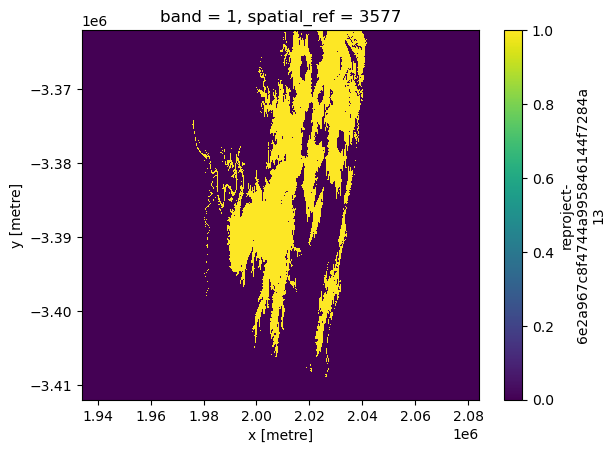

In [14]:
#Create a mask based on LiDAR_threshold
LiDAR_mask = xr.where((LiDAR_thres == False), 0, 1).astype('int8')

LiDAR_mask.plot()

In [15]:
print("GridSpec resolution:", gs_c3_expanded.resolution)

GridSpec resolution: Resolution(x=5, y=-5)


In [16]:
lidarAOI = xr.where(LiDAR_mask == 0, np.nan, ds2.values)

In [17]:
lidarAOI

<xarray.DataArray 'reproject-6e2a967c8f4744a995846144f7284a13' (y: 10000,
                                                                x: 30000)> Size: 1GB
dask.array<where, shape=(10000, 30000), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    band         int32 4B 1
  * y            (y) float64 80kB -3.362e+06 -3.362e+06 ... -3.412e+06
  * x            (x) float64 240kB 1.934e+06 1.934e+06 ... 2.084e+06 2.084e+06
    spatial_ref  int32 4B 3577

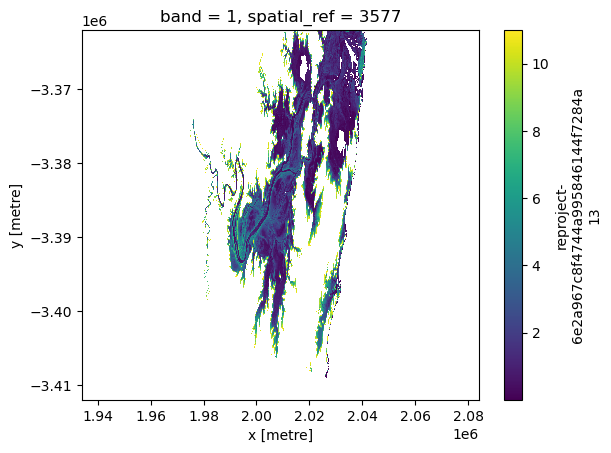

In [18]:
# Coarsen the data to make it smaller
lidarAOI_coarse = lidarAOI.coarsen(x=10, y=10, boundary="trim").mean()

# Now plot the reduced version
lidarAOI_coarse.plot()

# load HAT and SS

In [19]:
import geopandas as gpd

# Corrected file path
file_path = r"C:\Users\danie\OneDrive - The University Of Newcastle\2025\SCIE3500\Data\HAT_file.gpkg"

# Read the file
HAT_gpd = gpd.read_file(file_path)

# Convert to CRS 3577
HAT_gpd_EPSG3577 = HAT_gpd.to_crs("EPSG:3577")

In [20]:
import geopandas as gpd

# Corrected file path
file_path = r"C:\Users\danie\OneDrive - The University Of Newcastle\2025\SCIE3500\Data\STF_SS_ElevationClasses.geojson"

# Load the file
SS_gpd = gpd.read_file(file_path)

# Convert to CRS 3577
SS_gpd_EPSG3577 = SS_gpd.to_crs("EPSG:3577")

In [21]:
# TODO: Raf, why is this diffferent to previous code? - Raf to add comment
# HAT_SS_gpd = gpd.sjoin(HAT_gpd_EPSG3577, SS_gpd_EPSG3577, predicate='within')
HAT_SS_gpd = gpd.overlay(HAT_gpd_EPSG3577, SS_gpd_EPSG3577, how='intersection')

In [ ]:
# creating a new column in mainland_grid and populating with the sum of HAT and Storm Surge
HAT_SS_gpd['HATSS'] = HAT_SS_gpd['HAT'] + HAT_SS_gpd['SSElev']

In [ ]:
HAT_SS_gpd["geometry"] = HAT_SS_gpd.representative_point()

In [ ]:
assert HAT_SS_gpd.crs.to_epsg() == 3577

# interpolate HAT using srtm bounds

In [22]:
tile_size = 5000
x_range = range(0, lidarAOI.sizes['x'], tile_size)
y_range = range(0, lidarAOI.sizes['y'], tile_size)

for x0 in x_range:
    for y0 in y_range:
        x1 = min(x0 + tile_size, lidarAOI.sizes['x'])
        y1 = min(y0 + tile_size, lidarAOI.sizes['y'])

        print(f"🔄 Processing tile: x={x0}-{x1}, y={y0}-{y1}")

        lidar_tile = lidarAOI.isel(x=slice(x0, x1), y=slice(y0, y1))
        LiDAR_thres_tile = LiDAR_thres.isel(x=slice(x0, x1), y=slice(y0, y1))

        if (LiDAR_thres_tile == 1).sum() < 100:
            print("⚠️ Skipping tile (low valid pixel count)")
            continue

        try:
            interp_tile = xr_interpolate(
                ds=lidar_tile,
                gdf=HAT_SS_gpd,
                columns=['HAT', 'SSElev'],
                method="idw",
                #k=10
            )
            HAT = interp_tile.HAT
            SS = interp_tile.SSElev
            HATSS = HAT + SS

            # Zone 1: HAT to HAT + SS (normalized 1 to 0.5)
            HAT_storm = xr.where((lidar_tile > HAT) & (lidar_tile <= HATSS), lidar_tile, np.nan)
            min_val = HAT_storm.min()
            max_val = HAT_storm.max()
            norm_05_1 = ((1 - (HAT_storm - min_val) / (max_val - min_val)) / 2) + 0.5

            # Zone 2: HAT + SS to 11m (normalized 0.5 to 0)
            HAT_11 = xr.where((lidar_tile > HATSS) & (lidar_tile <= 11), lidar_tile, np.nan)
            norm_11 = ((1 - (HAT_11 - HAT_11.min()) / (11 - HAT_11.min())) / 2)

            # Combine zones
            supratidal = norm_05_1.fillna(0) + norm_11.fillna(0)

            # ✅ Set all very low values to 1.0 (yellow)
            supratidal = supratidal.where(supratidal != 0, 1.0)

            # Apply LiDAR mask
            supratidal_model = xr.where(LiDAR_thres_tile == 1, supratidal, np.nan)
            supratidal_model = supratidal_model.assign_attrs(crs="EPSG:3577")

            # Save output
            filename = f"SCF_elevation_model_Woody_x{x0}_y{y0}.tif"
            supratidal_model.odc.write_cog(filename)
            print(f"✅ Saved: {filename}")

        except Exception as e:
            print(f"❌ Error in tile x={x0}, y={y0}: {e}")


🔄 Processing tile: x=0-5000, y=0-5000
⚠️ Skipping tile (low valid pixel count)
🔄 Processing tile: x=0-5000, y=5000-10000
⚠️ Skipping tile (low valid pixel count)
🔄 Processing tile: x=5000-10000, y=0-5000
✅ Saved: SCF_elevation_model_Woody_x5000_y0.tif
🔄 Processing tile: x=5000-10000, y=5000-10000
✅ Saved: SCF_elevation_model_Woody_x5000_y5000.tif
🔄 Processing tile: x=10000-15000, y=0-5000
✅ Saved: SCF_elevation_model_Woody_x10000_y0.tif
🔄 Processing tile: x=10000-15000, y=5000-10000
✅ Saved: SCF_elevation_model_Woody_x10000_y5000.tif
🔄 Processing tile: x=15000-20000, y=0-5000
✅ Saved: SCF_elevation_model_Woody_x15000_y0.tif
🔄 Processing tile: x=15000-20000, y=5000-10000
✅ Saved: SCF_elevation_model_Woody_x15000_y5000.tif
🔄 Processing tile: x=20000-25000, y=0-5000
✅ Saved: SCF_elevation_model_Woody_x20000_y0.tif
🔄 Processing tile: x=20000-25000, y=5000-10000
✅ Saved: SCF_elevation_model_Woody_x20000_y5000.tif
🔄 Processing tile: x=25000-30000, y=0-5000
⚠️ Skipping tile (low valid pixel c

In [ ]:
print(buffered_geobox.crs)

In [ ]:
ds2